# What's a Copula, and Why Should I Care?

---

A [copula](https://en.wikipedia.org/wiki/Copula_(probability_theory)) is a useful concept from probability theory that help us model uncertainty. There's the *mathematical definition* of a copula, and then there's the *practical understanding* of a copula. This notebook is focused on the latter.

At the highest level, a copula is a mathematical tool that helps us model the *dependency* between random variables within a flexible framework. That framework is mathematically justified by [Skylar's Theorem](https://en.wikipedia.org/wiki/Copula_(probability_theory)#Sklar's_theorem), which endorses modeling uncertainty in terms of *marginals* and a *copula*. We'll look at examples of both below.

In [1]:
import grama as gr
import pandas as pd
import seaborn as sns
X = gr.Intention()

To illustrate, we will study a dataset of Aluminum material properties.

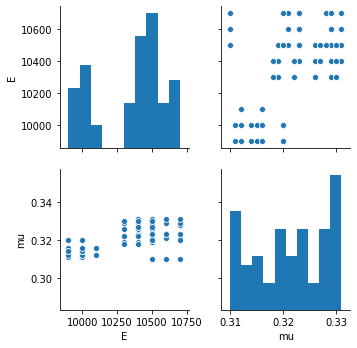

In [2]:
from grama.data import df_stang

sns.pairplot(
    df_stang,
    vars=["E", "mu"]
)

This is a [scatterplot matrix](https://en.wikipedia.org/wiki/Scatter_plot#Scatter_plot_matrices) of the two variables; since we only consider two variables in this setting, there is only one scatterplot (duplicated and reflected across the diagonal), and two histograms for the two variables.

The two histograms are essentially discrete estimates of the *marginals*. Both $E, \mu$ have some univariate distribution that describes their variability---this univariate distribution is a marginal.

However, the scatterplots also suggest that $E, \mu$ might not be independent; when $\mu$ is low then $E$ also tends to be low. Once we've decided on marginals for our variables (here $E, \mu$), we can use a copula to describe this kind of dependence.

### Modeling Random Material Properties

Below, we build a model for the variable aluminum properties. The following code fits continuous marginal distributions based on provided data.

In [3]:
md_aluminum = (
    gr.Model("Aluminum properties") >> \
    gr.cp_marginals(
        E=gr.marg_gkde(df_stang.E),
        mu=gr.marg_gkde(df_stang.mu)
    )
)


Note that in `py_grama`, we are *required* to specify a copula to relate the various inputs. Uncomment and execute the following line to see what happens when we *do not* define a copula.

In [4]:
# md_aluminum >> gr.ev_monte_carlo(n=100, df_det="nom")

The following code fixes an *independence copula* between the inputs; this modeling choice assumes that all inputs are completely independent. The following code also compares simulated draws from the model and compares them against the original dataset. This allows us to visually assess how well the model represents the data.

eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


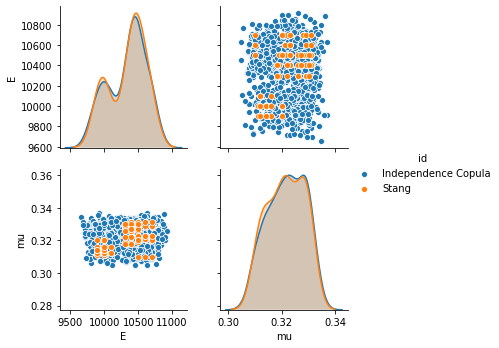

In [5]:
md_indep = (
    gr.Model("Aluminum properties")
    >> gr.cp_marginals(
        E=gr.marg_gkde(df_stang.E),
        mu=gr.marg_gkde(df_stang.mu)
    )
    >> gr.cp_copula_independence()
)

df_sim_indep = (
    md_indep
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True)
)

# Compare simulated and experimental data
sns.pairplot(
    df_sim_indep
    >> gr.tf_mutate(id="Independence Copula")
    >> gr.tf_bind_rows(df_stang >> gr.tf_mutate(id="Stang")),
    vars=["E", "mu"],
    hue="id"
)

Note that the simulated (`Sim`) data has similar marginals but does not exhibit the dependence of the original data (`Stang`). This shows us that the independence copula is a poor model for this case.

Instead, we can fit a *gaussian copula* to introduce some dependence between the variables. The following code fits a gaussian copula from the same data and performs the same visual comparison.

eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


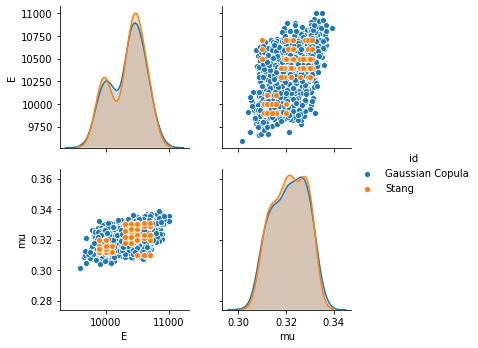

In [6]:
md_copula = (
    gr.Model("Aluminum properties")
    >> gr.cp_marginals(
        E=gr.marg_gkde(df_stang.E),
        mu=gr.marg_gkde(df_stang.mu)
    )
    >> gr.cp_copula_gaussian(df_data=df_stang)
)

df_sim_copula = (
    md_copula 
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True)
)

# Compare simulated and experimental results
sns.pairplot(
    df_sim_copula
    >> gr.tf_mutate(id="Gaussian Copula")
    >> gr.tf_bind_rows(df_stang >> gr.tf_mutate(id="Stang")),
    vars=["E", "mu"],
    hue="id"
)

Note that the simulated data now have positive correlation between $E, \mu$, which better reflects the original data.

### More on Copulas

The Wikipedia article on [copulas](https://en.wikipedia.org/wiki/Copula_(probability_theory)) gives a great deal more information on the subject. Gaussian copulas are a simple way to express dependence between variables, but there are highly elaborate means to construct more specialized models. Chapter 5, [Random vectors and objects](https://statweb.stanford.edu/~owen/mc/Ch-randvectors.pdf) of Art Owen's [Monte Carlo](https://statweb.stanford.edu/~owen/mc/) textbook gives some practical considerations and warnings about using Gaussian copulas.

## A brief mathematical primer

A copula enables a decomposition of a joint distribution into two objects:

1. The *marginals*, which describe each input
2. The *copula*, which describes how the inputs are related

We'll consider the 2D case for simplicity. Let $[X, Y]^{\top} ~ F$ be a joint density for $X$ and $Y$, where $F$ is the joint cdf. A *copula* allows us to express this distribution as

$$F(x, y) = C( F_x(x), F_y(y) ),$$

where $F_x, F_y$ are the *marginal distributions* for $X, Y$, and $C$ is the copula. The relation above is justified by *Skylar's Theorem*, which guarantees the existince of a copula-marginal decomposition for *any* distribution $F$.


### Marginals

The marginals $F_x, F_y$ for the example above were approximated by the histograms for the variables $E, \mu$ separately. We can estimate these in a variety of ways: By fitting a named distribution (e.g. a normal), or creating a kernel density estimate (as above). 


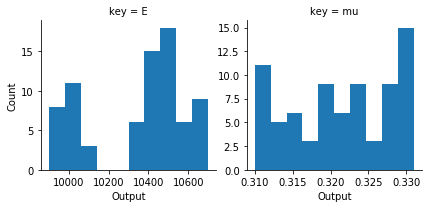

In [7]:
gr.plot_hists(
    df_stang,
    out=["E", "mu"]
)

### Copula

Once we have the marginals, we can visualize points in "copula space" by considering the transformed samples $F_x(X_i), F_y(Y_i)$; note that these are the inputs to the copula $C( F_x(x), F_y(y) )$. The following grama call carries out this marginal transform:


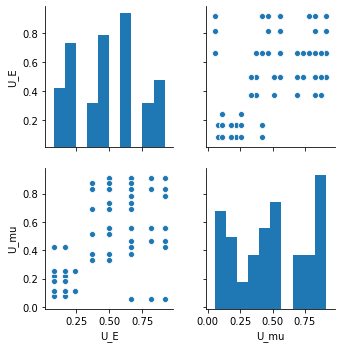

In [8]:
sns.pairplot(
    md_indep.density.sample2pr(df_stang)
    >> gr.tf_transmute(U_E=X.E, U_mu=X.mu),
    vars=["U_E", "U_mu"],
)

Note that the transformed variables `U_E, U_mu` now lie between $[0, 1]$. The `U_E, U_mu` should now have uniform *marginal* distributions, but they are not necessarily independent. We can see this above: the points in `U_E, U_mu` space seem to have some positive correlation. This is what the copula models, the joint dependence in this transformed space.
